In [11]:
from utils import Coord
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw
from IPython.display import display
import os

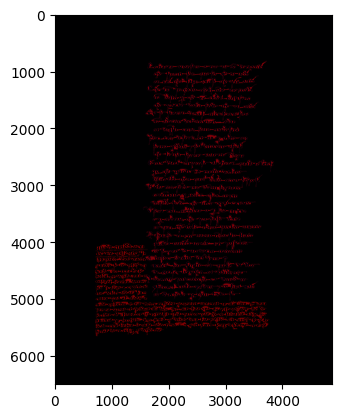

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = 'all/pixel-level-gt-CB55/pixel-level-gt/training/e-codices_fmb-cb-0055_0008v_max.png'

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.show()

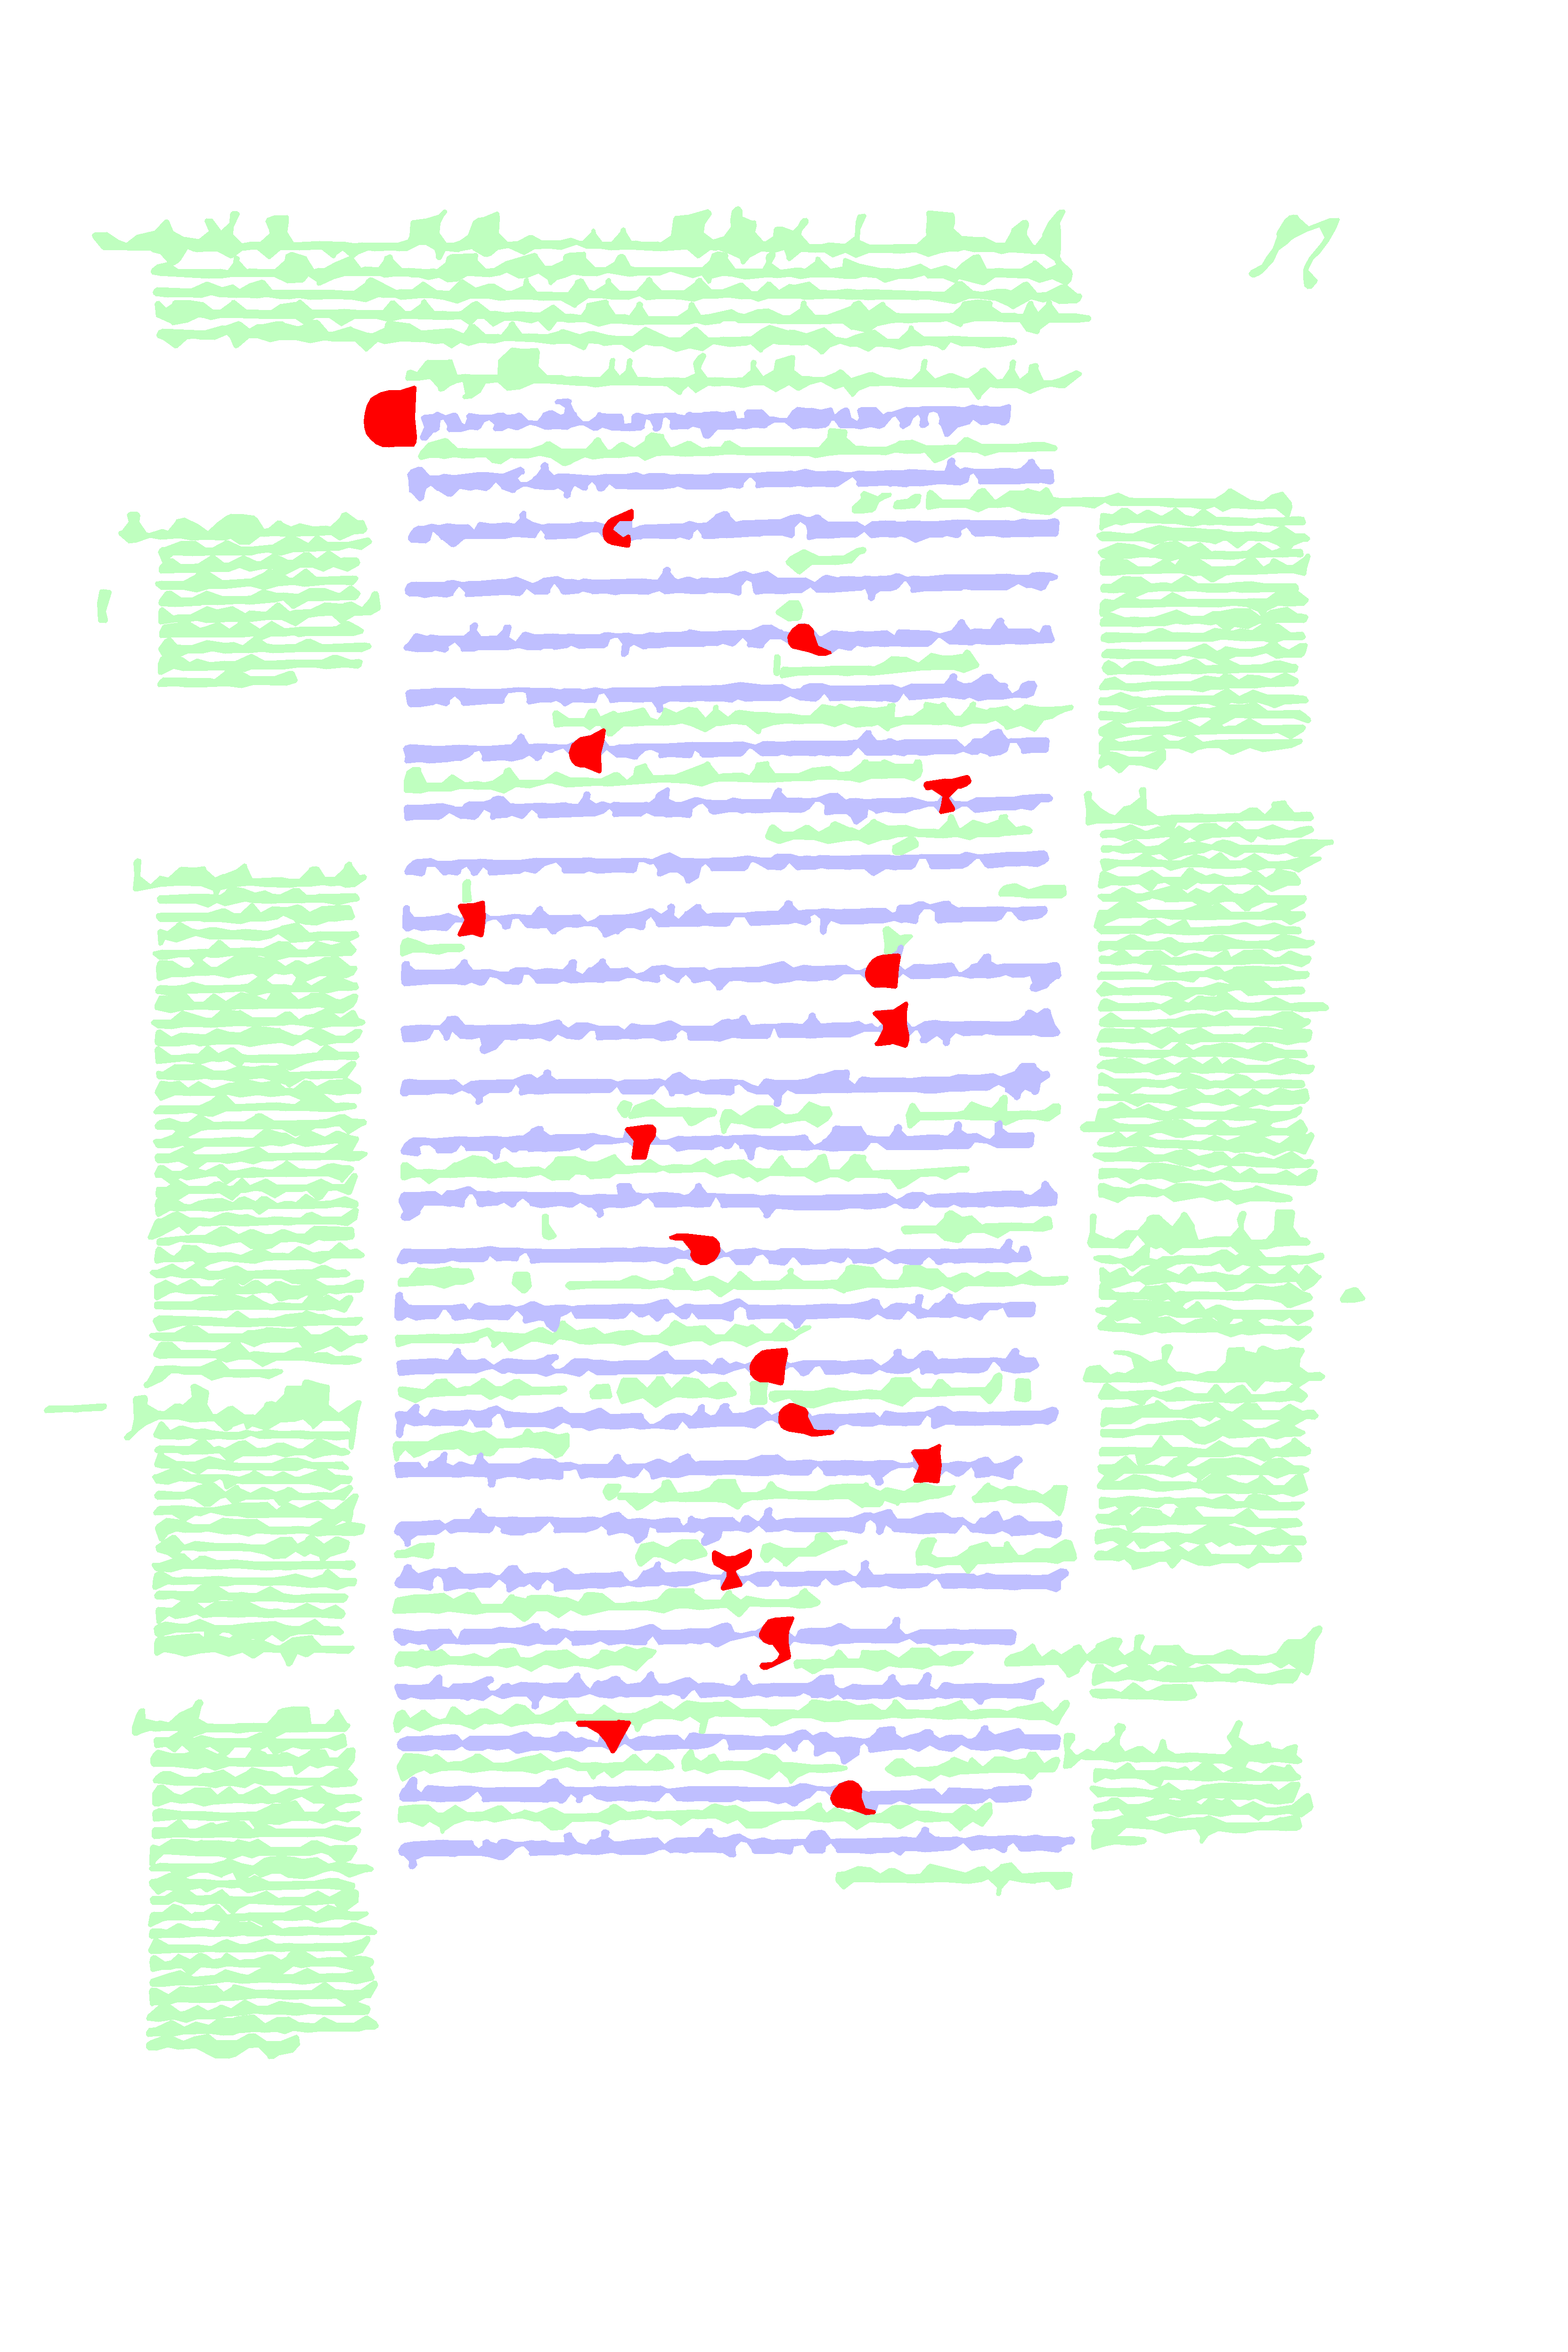

In [18]:
# Read the XML file
with open('all/PAGE-gt-CS18/PAGE-gt/training/e-codices_csg-0018_097_max.xml', 'r') as file:
    xml_data = file.read()

# Parse the XML using BeautifulSoup with 'lxml-xml' parser
soup = BeautifulSoup(xml_data, 'lxml-xml')

# Find all TextLine elements with an id containing 'comment'
textlines_with_comment = soup.find_all('GraphicRegion', {'id': lambda x: x and 'region' in x})

# Extract Coords points for each matching TextLine
coordinates_by_group = {"comment":[],"body":[],"decoration":[]}
search = {"comment":["TextLine","comment"],"body":["TextLine","textline"],"decoration":["GraphicRegion","region"]}
for group in coordinates_by_group.keys():
    textlines_with_comment = soup.find_all(search[group][0], {'id': lambda x: x and search[group][1] in x})
    for textline in textlines_with_comment:
        coords_points = textline.find('Coords')['points']
        coordinate_pairs = coords_points.split()
        coordinates_list = [tuple(map(int, pair.split(','))) for pair in coordinate_pairs]
        coordinates_by_group[group].append(coordinates_list)


image_path = 'all/img-CS18/img/training/e-codices_csg-0018_097_max.jpg'
img = Image.open(image_path)

colors = {"comment":(0, 255, 0, 64),"body":(0, 0, 255, 64),"decoration":(255,0, 0, 255)}
filled_polygon_img = Image.new('RGBA', img.size, (0, 0, 0, 0))
draw_filled_polygon = ImageDraw.Draw(filled_polygon_img)

for group in coordinates_by_group.keys():
    for coords in coordinates_by_group[group]:
        polygon_coordinates = coords

        draw_filled_polygon.polygon(polygon_coordinates,outline=None,fill=colors[group])

result_img = Image.alpha_composite(img.convert('RGBA'), filled_polygon_img)
display(filled_polygon_img)

In [8]:
import numpy as np
# Read the XML file
with open('all/PAGE-gt-CS18/PAGE-gt/training/e-codices_csg-0018_097_max.xml', 'r') as file:
    xml_data = file.read()

# Parse the XML using BeautifulSoup with 'lxml-xml' parser
soup = BeautifulSoup(xml_data, 'lxml-xml')

# Find all TextLine elements with an id containing 'comment'
textlines_with_comment = soup.find_all('GraphicRegion', {'id': lambda x: x and 'region' in x})

# Extract Coords points for each matching TextLine
coordinates_by_group = {"comment":[],"body":[],"decoration":[]}
search = {"comment":["TextLine","comment"],"body":["TextLine","textline"],"decoration":["GraphicRegion","region"]}
for group in coordinates_by_group.keys():
    textlines_with_comment = soup.find_all(search[group][0], {'id': lambda x: x and search[group][1] in x})
    for textline in textlines_with_comment:
        coords_points = textline.find('Coords')['points']
        coordinate_pairs = coords_points.split()
        coordinates_list = [tuple(map(int, pair.split(','))) for pair in coordinate_pairs]
        coordinates_by_group[group].append(coordinates_list)


image_path = 'all/img-CS18/img/training/e-codices_csg-0018_097_max.jpg'
img = Image.open(image_path)

colors = {"comment":1,"body":2,"decoration":3}
filled_polygon_img = Image.new('L', img.size)
draw_filled_polygon = ImageDraw.Draw(filled_polygon_img)
for group in coordinates_by_group.keys():
    print(group)
    for coords in coordinates_by_group[group]:
        polygon_coordinates = coords

        draw_filled_polygon.polygon(polygon_coordinates,outline=None,fill=colors[group])

gt_array = np.array(filled_polygon_img)

comment
body
decoration


In [7]:
gt_array

0.3100640712640224

In [25]:
class Page:
    def __init__(self,image,ground_truth,name):
        self.img = image
        self.gt = ground_truth
        self.name = name
    @classmethod
    def from_file(self,image_path:str = None,xml_path:str = None):
        if image_path and xml_path:
            with open(xml_path, 'r') as file:
                xml_data = file.read()

            # Parse the XML using BeautifulSoup with 'lxml-xml' parser
            soup = BeautifulSoup(xml_data, 'lxml-xml')

            # Extract Coords points for each matching TextLine
            coordinates_by_group = {"comment":[],"body":[],"decoration":[]}
            search = {"comment":["TextLine","comment"],"body":["TextLine","textline"],"decoration":["GraphicRegion","region"]}
            for group in coordinates_by_group.keys():
                textlines_with_comment = soup.find_all(search[group][0], {'id': lambda x: x and search[group][1] in x})
                for textline in textlines_with_comment:
                    coords_points = textline.find('Coords')['points']
                    coordinate_pairs = coords_points.split()
                    coordinates_list = [tuple(map(int, pair.split(','))) for pair in coordinate_pairs]
                    coordinates_by_group[group].append(coordinates_list)


            colors = {"comment":1,"body":2,"decoration":3}
            filled_polygon_img = Image.new('L', img.size)
            draw_filled_polygon = ImageDraw.Draw(filled_polygon_img)
            for group in coordinates_by_group.keys():
                for coords in coordinates_by_group[group]:
                    polygon_coordinates = coords

                    draw_filled_polygon.polygon(polygon_coordinates,outline=None,fill=colors[group])


            return Page(np.array(Image.open(image_path))/255,np.array(filled_polygon_img),image_path[image_path.rfind("/")+1:image_path.find(".")])
    def __repr__(self):
        return f"Page={self.name}"


In [29]:
def parse_images_from_folder(image_path, xml_path):
    xml_files = os.listdir(xml_path)
    image_files = os.listdir(image_path)
    output = []
    for i in range(len(xml_files)):
        img_file_path = image_path + "/" + image_files[i]
        xml_file_path = xml_path + "/" + xml_files[i]
        page = Page.from_file(img_file_path,xml_file_path)
        output.append(page)
    return output

haha = parse_images_from_folder("all/img-CS18/img/training","all/PAGE-gt-CS18/PAGE-gt/training")

In [31]:
haha[0]

232

In [28]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0','deeplabv3_resnet50',pretrained=True)

Using cache found in C:\Users\dator/.cache\torch\hub\pytorch_vision_v0.10.0
